In [4]:
import wfdb
import os
import pprint
import matplotlib.pyplot as plt
import pandas as pd
import zipfile as zf
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from scipy.signal import butter, filtfilt, find_peaks

# 1. Introduction

## 1.1 Dataset and Reference

The dataset used in this project is publicly available from [PhysioNet: ECG, Skin Conductance, and Respiration from Spider-Fearful Individuals](https://physionet.org/content/ecg-spider-clip/1.0.0/). It includes raw biosignals recorded using BITalino sensors from participants exposed to anxiety-inducing spider video clips and resting phases.

This work is based on and inspired by the study:

> Ihmig, F. R., Gogeascoechea, A., Neurohr-Parakenings, F., Schäfer, S. K., Lass-Hennemann, J., & Michael, T. (2020). On-line anxiety level detection from biosignals: Machine learning based on a randomized controlled trial with spider-fearful individuals. *PLOS ONE*, [PMC7310735](https://pmc.ncbi.nlm.nih.gov/articles/PMC7310735/#abstract1).


## 1.2 ECG-Spider-Clip Dataset: Files and Data Structure Summary

### 1.2.1 Directory Structure

Each of the **57 participants** (labeled `VPxx`) has an individual directory containing raw biosignal data recorded as separate text files (`.txt`):

Example directory structure:

![Data Structure](structure.png)


---

### 1.2.2 Description of Files and Data Content

Each participant’s directory contains four main text files:

| File Name          | Content Description               | Unit              | Value Range             | Additional Notes                                    |
|--------------------|-----------------------------------|-------------------|-------------------------|-----------------------------------------------------|
| `BitalinoBR.txt`   | **Respiration signal**            | %                 | -50% to +50%            | Piezoelectric sensor deflection on chest strap      |
| `BitalinoECG.txt`  | **Electrocardiogram (ECG)**       | mV                | -1.5 mV to +1.5 mV      | Raw electrical heart activity                       |
| `BitalinoGSR.txt`  | **Skin Conductance (GSR)**        | µS (microsiemens) | -12.6 µS to +41 µS      | Negative values require offset correction           |
| `Triggers.txt`     | Video stimulus identifiers        | text IDs          | CLIP-1 to CLIP-16 and BIOFEEDBACK-REST | Video clip/phase ID with timestamps for start and end |

---

### 1.2.3 Data Format within Files

#### Signal files (`BitalinoBR.txt`, `BitalinoECG.txt`, `BitalinoGSR.txt`):

| Column | Description                    | Example          | Comments                            |
|--------|--------------------------------|------------------|-------------------------------------|
| 1      | Signal Value                   | e.g., `0.45`     | Raw sensor reading                  |
| 2      | Timestamp                      | e.g., `104502.010` | Format: `hhmmss.milliseconds`       |
| 3      | Label (`RAW`)                  | e.g., `RAW`      | Can be ignored                      |

> **Note:** Timestamps might be irregular due to the Windows timestamp generation, despite a set sampling rate of **100 Hz**.

#### Trigger file (`Triggers.txt`):

| Column | Description                              | Example          | Comments                                |
|--------|------------------------------------------|------------------|-----------------------------------------|
| 1      | Trigger ID (video clip/phase)            | `CLIP-1`         | 16 clips + BIOFEEDBACK-REST             |
| 2      | Start timestamp (`hhmmss`)               | e.g., `104502`   | Start time of video clip/phase          |
| 3      | End timestamp (`hhmmss`)                 | e.g., `104602`   | End time of video clip/phase            |

---

### 1.2.4 Additional Files

- **`subject_groups.csv`**  
  CSV table indicating group assignment of participants.

- **`screenshot_spider.tif`**  
  Example screenshot from spider video clips (original videos unavailable due to copyright).

- **`LICENSE.txt`**  
  Dataset license (**Open Data Commons Attribution License v1.0**).

---

### 1.2.5 Research Context

- Participants: Individuals with spider fear (arachnophobia), exposed to spider video clips.
- Objective: Analyzing anxiety levels and evaluating the effectiveness of HRV biofeedback during exposure therapy.
- Data suitable for machine-learning-based anxiety detection and emotion classification.

---

### 1.2.6 Potential Applications of the Dataset

- **Signal processing:** Filtering, feature extraction from ECG, GSR, and respiratory signals.
- **Machine Learning:** Emotion/anxiety level classification (fear vs neutral).
- **Data visualization:** Exploring correlations between biosignals and emotional states.

---

The dataset provides clearly structured physiological data (ECG, GSR, respiration) collected from participants viewing anxiety-inducing spider clips. Data are organized in separate participant folders and can be easily imported and analyzed in Python.

This dataset is excellent for learning signal processing techniques, data visualization, and basic machine learning applied to psychophysiological data.


## 1.3 Extracting and reviewing available data

In [5]:
data_path = "DATA/electrocardiogram-skin-conductance-and-respiration-from-spider-fearful-individuals-watching-spider-video-clips-1.0.0/"
df_subject_groups = pd.read_csv(data_path + 'subject_groups.csv')
print(df_subject_groups)

   Group2 Group3 Group4
0    VP02   VP03   VP61
1    VP05   VP06   VP62
2    VP08   VP09   VP63
3    VP11   VP12   VP64
4    VP14   VP15   VP65
5    VP17   VP18   VP66
6    VP20   VP24   VP68
7    VP23   VP27   VP69
8    VP26   VP30   VP70
9    VP29   VP33   VP71
10   VP32   VP36   VP72
11   VP35   VP39   VP73
12   VP38   VP42   VP74
13   VP41   VP45   VP75
14   VP44   VP48   VP76
15   VP47   VP51   VP77
16   VP50   VP54   VP78
17   VP53   VP57   VP79
18   VP56    NaN   VP80
19   VP59    NaN    NaN


In [6]:
subject_dirs = sorted([name for name in os.listdir(data_path) if name.startswith("VP")])
print(f"Found {len(subject_dirs)} subjects:")
print(subject_dirs)


Found 57 subjects:
['VP02', 'VP03', 'VP05', 'VP06', 'VP08', 'VP09', 'VP11', 'VP12', 'VP14', 'VP15', 'VP17', 'VP18', 'VP20', 'VP23', 'VP24', 'VP26', 'VP27', 'VP29', 'VP30', 'VP32', 'VP33', 'VP35', 'VP36', 'VP38', 'VP39', 'VP41', 'VP42', 'VP44', 'VP45', 'VP47', 'VP48', 'VP50', 'VP51', 'VP53', 'VP54', 'VP56', 'VP57', 'VP59', 'VP61', 'VP62', 'VP63', 'VP64', 'VP65', 'VP66', 'VP68', 'VP69', 'VP70', 'VP71', 'VP72', 'VP73', 'VP74', 'VP75', 'VP76', 'VP77', 'VP78', 'VP79', 'VP80']


# 2. ECG Processing

## 2.1 Loading and filtering ECG signals

To preprocess the ECG signal and remove unwanted noise, I use a **Butterworth bandpass filter** with a low cutoff frequency (`lowcut = 5 Hz`) and a high cutoff frequency (`highcut = 12 Hz`). 

This range is chosen because:
- **QRS complexes**, which I aim to detect, typically fall within the **5–15 Hz** frequency band.
- Frequencies **below 5 Hz** (e.g. baseline drift, movement artifacts) and **above 12 Hz** (e.g. muscle noise) are filtered out to enhance R-peak detection.

#### 🔧 Filter Hyperparameters
- `N=4`: The filter order; higher orders result in a steeper frequency cutoff.
- `Wn=[lowcut, highcut]`: The normalized passband range.
- `btype='band'`: Specifies a bandpass filter.
- `fs=100`: The sampling frequency of the signal (100 Hz in our case).

The filtered signal is then passed through additional Pan-Tompkins steps to accurately detect R-peaks.

In [7]:
fs = 100  
lowcut, highcut = 5, 12
b, a = butter(N=4, Wn=[lowcut, highcut], btype='band', fs=fs)

ecg_signals = {}

for subject in subject_dirs:
    ecg_path = os.path.join(data_path, subject, "BitalinoECG.txt")

    try:
        ecg_data = pd.read_csv(ecg_path, sep='\t', header=None)
        ecg_data.columns = ['ECG_mV', 'Timestamp', 'Raw'] #manually setting the names of the columns
        ecg_signal = ecg_data['ECG_mV'].values
        
        ecg_filtered = filtfilt(b, a, ecg_signal)
        
        ecg_signals[subject] = ecg_filtered
        print(f"{subject} loaded and filtered.")
        
    except Exception as e:
        print(f" Error loading {subject}: {e}")


VP02 loaded and filtered.
VP03 loaded and filtered.
VP05 loaded and filtered.
VP06 loaded and filtered.
VP08 loaded and filtered.
VP09 loaded and filtered.
VP11 loaded and filtered.
VP12 loaded and filtered.
VP14 loaded and filtered.
VP15 loaded and filtered.
VP17 loaded and filtered.
VP18 loaded and filtered.
VP20 loaded and filtered.
VP23 loaded and filtered.
VP24 loaded and filtered.
VP26 loaded and filtered.
VP27 loaded and filtered.
VP29 loaded and filtered.
VP30 loaded and filtered.
VP32 loaded and filtered.
VP33 loaded and filtered.
VP35 loaded and filtered.
VP36 loaded and filtered.
VP38 loaded and filtered.
VP39 loaded and filtered.
VP41 loaded and filtered.
VP42 loaded and filtered.
VP44 loaded and filtered.
VP45 loaded and filtered.
VP47 loaded and filtered.
VP48 loaded and filtered.
VP50 loaded and filtered.
VP51 loaded and filtered.
VP53 loaded and filtered.
VP54 loaded and filtered.
VP56 loaded and filtered.
VP57 loaded and filtered.
VP59 loaded and filtered.
VP61 loaded 

## 2.2 Aligning and Segmenting ECG Using Triggers

Each subject's ECG signal is segmented based on **trigger events** defined in `Triggers.txt`. These events correspond to time windows when participants were exposed to specific stimuli (e.g. spider video clips or rest).

#### Why Alignment Is Needed
The timestamps in the trigger file (format `HHMMSS`) need to be **aligned** with the actual start time of the ECG recording to determine the correct sample indices.

What did I do:
1. **Extract the start time** of the ECG recording (`Timestamp` from the first sample).
2. **Convert all trigger timestamps** (`Start_hhmmss`, `End_hhmmss`) to seconds.
3. **Calculate relative time** of each trigger by subtracting the ECG start time.
4. **Convert seconds to sample indices** using the sampling frequency (`fs = 100` Hz).

#### Segmenting the Signal
Once start and end sample indices are computed, I:
- Slice the filtered ECG signal for each trigger.
- Store these segments in a dictionary, organized by subject and trigger label.

This enables us to extract **physiological features** for specific conditions (e.g. CLIP-1, REST) later in the pipeline.


In [8]:
def hhmmss_to_seconds(hhmmss):
    hhmmss = str(int(hhmmss)).zfill(6) #ensuring that it's a 6 digit string
    h, m, s = int(hhmmss[:2]), int(hhmmss[2:4]), int(hhmmss[4:6])
    return h * 3600 + m * 60 + s #converting to total seconds

def hhmmss_float_to_seconds(hhmmss_float): #in case there's a float part
    base = hhmmss_to_seconds(int(hhmmss_float)) #converting integer part
    return base + (hhmmss_float % 1) #and adding the decimal part to it

ecg_segments = {}

for subject in subject_dirs:
    try:
        ecg_path = os.path.join(data_path, subject, "BitalinoECG.txt")
        ecg_data = pd.read_csv(ecg_path, sep='\t', header=None)
        ecg_data.columns = ['ECG_mV', 'Timestamp', 'Raw']
        ecg_start_ts = ecg_data['Timestamp'].iloc[0] #extracting the timestamp of the first ECG sample
        ecg_start_sec = hhmmss_float_to_seconds(ecg_start_ts)

        trig_path = os.path.join(data_path, subject, "Triggers.txt") 
        df_trig = pd.read_csv(trig_path, sep='\t', header=None, names=['Trigger_ID', 'Start_hhmmss', 'End_hhmmss'])

        #converting start/end times to second andgning with  the ECG start time
        df_trig['start_sec'] = df_trig['Start_hhmmss'].apply(hhmmss_to_seconds) - ecg_start_sec 
        df_trig['end_sec'] = df_trig['End_hhmmss'].apply(hhmmss_to_seconds) - ecg_start_sec

        #converting seconds to sample indices using sampling frequency
        df_trig['start_sample'] = (df_trig['start_sec'] * fs).astype(int)
        df_trig['end_sample'] = (df_trig['end_sec'] * fs).astype(int)

        #retrieving the pre-filtered ECG signal
        ecg_filtered = ecg_signals[subject]
        subject_segments = {}

        for _, row in df_trig.iterrows():
            trig = row['Trigger_ID']
            start, end = row['start_sample'], row['end_sample']
            
            if 0 <= start < end <= len(ecg_filtered):
                segment = ecg_filtered[start:end]
                subject_segments[trig] = segment
        
        ecg_segments[subject] = subject_segments
        print(f"{subject} triggers aligned and ECG segmented.")

    except Exception as e:
        print(f" Error processing {subject}: {e}")


VP02 triggers aligned and ECG segmented.
VP03 triggers aligned and ECG segmented.
VP05 triggers aligned and ECG segmented.
VP06 triggers aligned and ECG segmented.
VP08 triggers aligned and ECG segmented.
VP09 triggers aligned and ECG segmented.
VP11 triggers aligned and ECG segmented.
VP12 triggers aligned and ECG segmented.
VP14 triggers aligned and ECG segmented.
VP15 triggers aligned and ECG segmented.
VP17 triggers aligned and ECG segmented.
VP18 triggers aligned and ECG segmented.
VP20 triggers aligned and ECG segmented.
VP23 triggers aligned and ECG segmented.
VP24 triggers aligned and ECG segmented.
VP26 triggers aligned and ECG segmented.
VP27 triggers aligned and ECG segmented.
VP29 triggers aligned and ECG segmented.
VP30 triggers aligned and ECG segmented.
VP32 triggers aligned and ECG segmented.
VP33 triggers aligned and ECG segmented.
VP35 triggers aligned and ECG segmented.
VP36 triggers aligned and ECG segmented.
VP38 triggers aligned and ECG segmented.
VP39 triggers al

## 2.3 Pan-Tompkins R-Peak Detection (Manual Implementation)

To detect R-peaks in the ECG signal, I use a simplified manual implementation of the **Pan-Tompkins algorithm**. This algorithm is widely used for real-time QRS complex detection and relies on time-domain transformations and adaptive thresholding.

#### Steps in `pan_tompkins_detect`:

1. **Bandpass Filtering (5–12 Hz)**  
   Removes noise and enhances QRS components.

2. **Differentiation**  
   Highlights the rapid changes in slope typical of the QRS complex.  
   A kernel like `[1, 2, 0, -2, -1]` is used to compute the derivative.

3. **Squaring**  
   Makes all values positive and accentuates large slopes.

4. **Moving Window Integration (MWI)**  
   Smooths the signal using a moving average to highlight the energy envelope of the QRS complex.

5. **Thresholding + Decision Rule**  
   Peaks in the MWI signal are detected and classified using two adaptive thresholds:
   - `SPKI`: Running average of signal peaks (true QRS).
   - `NPKI`: Running average of noise peaks.
   - Two thresholds (`THRESHOLD1` and `THRESHOLD2`) dynamically adjust based on peak amplitude.

   Peaks above `THRESHOLD1` are considered **R-peaks** and appended to the `qrs_peaks` list.

#### Output
The function returns the final list of **R-peak indices**, which are used to calculate RR intervals and derive HRV metrics.

This implementation provides good control and understanding of the signal processing steps involved in ECG analysis.


In [9]:
def pan_tompkins_detect(ecg_segment, fs=100):
    #1 -- Differentiation
    diff_kernel = np.array([1, 2, 0, -2, -1]) * (1/8) * fs
    ecg_diff = np.convolve(ecg_segment, diff_kernel, mode='same')

    #2 -- Squaring
    ecg_squared = ecg_diff ** 2

    #3 -- MWI
    window_size = int(0.15 * fs)
    ecg_mwi = np.convolve(ecg_squared, np.ones(window_size) / window_size, mode='same')

    #4 -- Peak Detection
    threshold = 0.2 * np.max(ecg_mwi)
    peak_candidates, _ = find_peaks(ecg_mwi, height=threshold, distance=int(0.3 * fs))

    #5 -- Adaptive Thresholding
    SPKI = 0.0
    NPKI = 0.0
    qrs_peaks = []
    noise_peaks = []

    for p in peak_candidates:
        peak_amp = ecg_mwi[p]

        THRESHOLD1 = NPKI + 0.25 * (SPKI - NPKI)
        THRESHOLD2 = 0.5 * THRESHOLD1

        if peak_amp >= THRESHOLD1:
            qrs_peaks.append(p)
            SPKI = 0.125 * peak_amp + 0.875 * SPKI
        elif THRESHOLD2 <= peak_amp < THRESHOLD1:
            noise_peaks.append(p)
            NPKI = 0.125 * peak_amp + 0.875 * NPKI
        else:
            noise_peaks.append(p)
            NPKI = 0.125 * peak_amp + 0.875 * NPKI

    return np.array(qrs_peaks), ecg_mwi

In [10]:
qrs_peaks_dict = {}

for subject, segments in ecg_segments.items():
    qrs_peaks_dict[subject] = {}
    for trig, segment in segments.items():
        try:
            peaks, _ = pan_tompkins_detect(segment, fs=fs)
            qrs_peaks_dict[subject][trig] = peaks
        except Exception as e:
            print(f" Error in {subject} - {trig}: {e}")

In [12]:
def plot_pan_tompkins_segment(subject, trigger, window_seconds=5):
    ecg_segment = ecg_segments[subject][trigger]
    peaks, ecg_mwi = pan_tompkins_detect(ecg_segment, fs=fs)

    mid = len(ecg_mwi) // 2
    half_window = int((window_seconds * fs) // 2)
    start = mid - half_window
    end = mid + half_window

    peaks_in_range = peaks[(peaks >= start) & (peaks < end)]

    plt.figure(figsize=(12, 4))
    plt.plot(range(start, end), ecg_mwi[start:end], label='MWI', color='gray')
    plt.plot(peaks_in_range, ecg_mwi[peaks_in_range], 'ro', label='Detected R-peaks')
    plt.title(f'{subject} - {trigger} (Middle {window_seconds} seconds)')
    plt.xlabel('Sample index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 2.4 R-peak Detection Using the Pan-Tompkins Method — VP02, CLIP-1


The plot below shows the result of applying the **Pan-Tompkins algorithm** to a segment of the ECG signal (the middle 5 seconds from the `CLIP-1` segment of subject `VP02`).

- The **black line** represents the preprocessed signal using Moving Window Integration (MWI), which highlights the QRS complex energy.
- The **red dots** indicate detected R-peaks — local maxima in the MWI signal that exceed the adaptive threshold.

The algorithm performs well, accurately identifying R-peaks, which is essential for further heart rate variability (HRV) analysis.

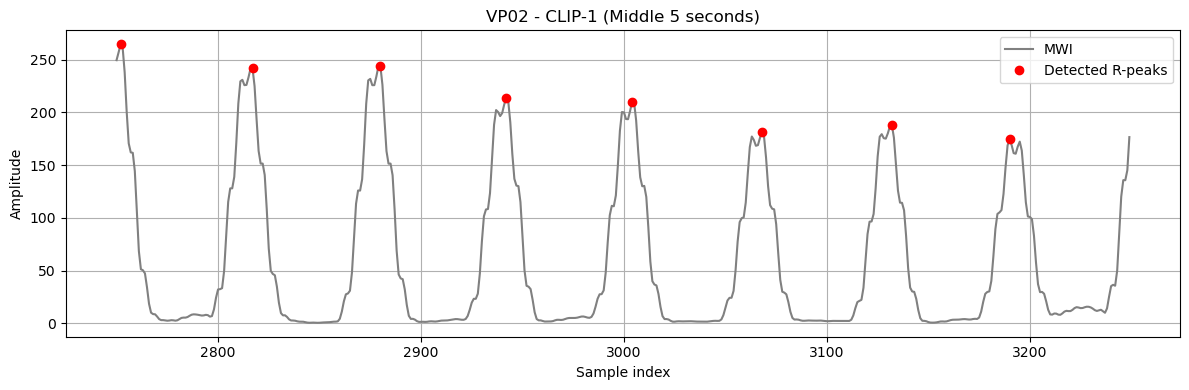

In [13]:
plot_pan_tompkins_segment('VP02', 'CLIP-1')

## 2.5 Heart Rate Variability (HRV) Feature Extraction

After detecting the R-peaks in the ECG signal, I calculate several standard **HRV (Heart Rate Variability)** features for each segment. These features provide insights into the autonomic nervous system and stress or relaxation states.

The extracted HRV features are:

- **Mean RR Interval (`mean_rr`)**: Average time between successive R-peaks (in milliseconds). A shorter mean RR generally reflects higher heart rate.
  
- **SDNN (`sdnn`)**: Standard deviation of RR intervals. Represents overall HRV — higher values indicate a more adaptable cardiovascular system.
  
- **RMSSD (`rmssd`)**: Root mean square of successive RR interval differences. A strong marker for parasympathetic (rest/digest) activity.
  
- **pNN50 (`pnn50`)**: Percentage of consecutive RR intervals differing by more than 50 ms. Also associated with parasympathetic regulation.

These features are used as part of the input for machine learning models to classify stress levels during various stimulus phases (e.g., watching spider videos vs. resting).


In [14]:
def extract_hrv_features(peaks, fs=100):
    if len(peaks) < 2:
        return None  #not enough peaks
    
    rr_intervals = np.diff(peaks) / fs  #seconds
    rr_ms = rr_intervals * 1000  #->ms

    mean_rr = np.mean(rr_ms)
    sdnn = np.std(rr_ms)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_ms))))
    nn50 = np.sum(np.abs(np.diff(rr_ms)) > 50)
    pnn50 = (nn50 / len(rr_ms)) * 100

    return {
        'mean_rr': mean_rr,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'pnn50': pnn50
    }

In [16]:
hrv_features = {}

for subject in qrs_peaks_dict:
    hrv_features[subject] = {}
    for trig in qrs_peaks_dict[subject]:
        peaks = qrs_peaks_dict[subject][trig]
        features = extract_hrv_features(peaks, fs=fs)
        if features:
            hrv_features[subject][trig] = features


In [18]:
pprint.pprint(hrv_features['VP02'])

{'BIOFEEDBACK-OXYGEN-TRAININGS': {'mean_rr': 677.7198027937551,
                                  'pnn50': 23.623664749383728,
                                  'rmssd': 65.81432113468965,
                                  'sdnn': 83.78339277255618},
 'BIOFEEDBACK-REST': {'mean_rr': 653.6383442265795,
                      'pnn50': 12.200435729847495,
                      'rmssd': 43.531346934581116,
                      'sdnn': 78.76254217848391},
 'CLIP-1': {'mean_rr': 638.0434782608696,
            'pnn50': 20.652173913043477,
            'rmssd': 48.01556524185158,
            'sdnn': 55.81878931037124},
 'CLIP-10': {'mean_rr': 708.2142857142857,
             'pnn50': 25.0,
             'rmssd': 47.579989719279546,
             'sdnn': 64.5342418205013},
 'CLIP-11': {'mean_rr': 686.9767441860465,
             'pnn50': 31.3953488372093,
             'rmssd': 52.658723650223315,
             'sdnn': 81.93970794576268},
 'CLIP-12': {'mean_rr': 681.7045454545455,
             'pnn50'

# 3. GSR Processing

## 3.1 GSR Signal Filtering

The Galvanic Skin Response (GSR) signal was filtered using a **low-pass Butterworth filter** to remove high-frequency noise and retain slower skin conductance changes, which are relevant for emotional and stress-related analysis.

#### Filter Details:
- **Type**: Low-pass
- **Order (`N`)**: 4  
  A 4th-order filter provides a good balance between smoothness and responsiveness.
  
- **Cutoff Frequency (`Wn`)**: 1.0 Hz  
  This value keeps slower variations in the signal (typical for skin conductance) while attenuating fast, noisy fluctuations.

- **Sampling Frequency (`fs`)**: 100 Hz  
  This was the original sampling rate of the dataset, applied consistently across all signals.

The filtered GSR signal for each subject is stored and used in later segmentation and feature extraction.

In [19]:
cutoff_gsr = 1.0
b_gsr, a_gsr = butter(N=4, Wn=cutoff_gsr, btype='low', fs=fs)

gsr_signals = {}

for subject in subject_dirs:
    gsr_path = os.path.join(data_path, subject, "BitalinoGSR.txt")
    try:
        gsr_data = pd.read_csv(gsr_path, sep='\t', header=None)
        gsr_data.columns = ['GSR_uS', 'Timestamp', 'Raw']
        gsr_signal = gsr_data['GSR_uS'].values

        gsr_filtered = filtfilt(b_gsr, a_gsr, gsr_signal)

        gsr_signals[subject] = gsr_filtered
        print(f"{subject} GSR loaded and filtered.")
        
    except Exception as e:
        print(f" Error loading GSR for {subject}: {e}")

VP02 GSR loaded and filtered.
VP03 GSR loaded and filtered.
VP05 GSR loaded and filtered.
VP06 GSR loaded and filtered.
VP08 GSR loaded and filtered.
VP09 GSR loaded and filtered.
VP11 GSR loaded and filtered.
VP12 GSR loaded and filtered.
VP14 GSR loaded and filtered.
VP15 GSR loaded and filtered.
VP17 GSR loaded and filtered.
VP18 GSR loaded and filtered.
VP20 GSR loaded and filtered.
VP23 GSR loaded and filtered.
VP24 GSR loaded and filtered.
VP26 GSR loaded and filtered.
VP27 GSR loaded and filtered.
VP29 GSR loaded and filtered.
VP30 GSR loaded and filtered.
VP32 GSR loaded and filtered.
VP33 GSR loaded and filtered.
VP35 GSR loaded and filtered.
VP36 GSR loaded and filtered.
VP38 GSR loaded and filtered.
VP39 GSR loaded and filtered.
VP41 GSR loaded and filtered.
VP42 GSR loaded and filtered.
VP44 GSR loaded and filtered.
VP45 GSR loaded and filtered.
VP47 GSR loaded and filtered.
VP48 GSR loaded and filtered.
VP50 GSR loaded and filtered.
VP51 GSR loaded and filtered.
VP53 GSR l

## 3.2 Segmenting GSR Using Triggers

The GSR signal was segmented using the same time-based trigger information as used for ECG. Each subject's recording was aligned to the starting timestamp, and corresponding start and end times (from `Triggers.txt`) were converted into sample indices.

These segments correspond to specific experimental phases such as spider exposure clips, biofeedback training, and resting periods. The segmentation allows us to extract meaningful features from GSR in a context-aware manner, mirroring the structure used for ECG.

In [20]:
gsr_segments = {}

for subject in subject_dirs:
    try:
        trig_path = os.path.join(data_path, subject, "Triggers.txt")
        df_trig = pd.read_csv(trig_path, sep='\t', header=None, names=['Trigger_ID', 'Start_hhmmss', 'End_hhmmss'])

        gsr_data = pd.read_csv(os.path.join(data_path, subject, "BitalinoGSR.txt"), sep='\t', header=None)
        gsr_data.columns = ['GSR_uS', 'Timestamp', 'Raw']
        gsr_start_sec = hhmmss_float_to_seconds(gsr_data['Timestamp'].iloc[0])

        df_trig['start_sec'] = df_trig['Start_hhmmss'].apply(hhmmss_to_seconds) - gsr_start_sec
        df_trig['end_sec'] = df_trig['End_hhmmss'].apply(hhmmss_to_seconds) - gsr_start_sec
        df_trig['start_sample'] = (df_trig['start_sec'] * fs).astype(int)
        df_trig['end_sample'] = (df_trig['end_sec'] * fs).astype(int)

        subject_segments = {}
        gsr_filtered = gsr_signals[subject]

        for _, row in df_trig.iterrows():
            trig = row['Trigger_ID']
            start = row['start_sample']
            end = row['end_sample']

            if 0 <= start < end <= len(gsr_filtered):
                segment = gsr_filtered[start:end]
                subject_segments[trig] = segment

        gsr_segments[subject] = subject_segments
        print(f"{subject} GSR segmented.")

    except Exception as e:
        print(f" Error segmenting GSR for {subject}: {e}")


VP02 GSR segmented.
VP03 GSR segmented.
VP05 GSR segmented.
VP06 GSR segmented.
VP08 GSR segmented.
VP09 GSR segmented.
VP11 GSR segmented.
VP12 GSR segmented.
VP14 GSR segmented.
VP15 GSR segmented.
VP17 GSR segmented.
VP18 GSR segmented.
VP20 GSR segmented.
VP23 GSR segmented.
VP24 GSR segmented.
VP26 GSR segmented.
VP27 GSR segmented.
VP29 GSR segmented.
VP30 GSR segmented.
VP32 GSR segmented.
VP33 GSR segmented.
VP35 GSR segmented.
VP36 GSR segmented.
VP38 GSR segmented.
VP39 GSR segmented.
VP41 GSR segmented.
VP42 GSR segmented.
VP44 GSR segmented.
VP45 GSR segmented.
VP47 GSR segmented.
VP48 GSR segmented.
VP50 GSR segmented.
VP51 GSR segmented.
VP53 GSR segmented.
VP54 GSR segmented.
VP56 GSR segmented.
VP57 GSR segmented.
VP59 GSR segmented.
VP61 GSR segmented.
VP62 GSR segmented.
VP63 GSR segmented.
VP64 GSR segmented.
VP65 GSR segmented.
VP66 GSR segmented.
VP68 GSR segmented.
VP69 GSR segmented.
VP70 GSR segmented.
VP71 GSR segmented.
VP72 GSR segmented.
VP73 GSR segmented.


In [21]:
gsr_segments['VP02']['CLIP-1'] 

array([16.03389304, 16.03115458, 16.0283871 , ..., 15.27203335,
       15.26269655, 15.25334193])

## 3.3 GSR Peak Detection & Feature Extraction
To analyze the Galvanic Skin Response (GSR), I apply **peak detection** to identify short-term changes in skin conductance that are often linked to arousal and stress.


#### Peak Detection
I detect peaks in the **filtered GSR signal** using `scipy.signal.find_peaks()`. A peak is defined as a local maximum that surpasses a minimum height and is spaced apart from neighboring peaks by at least a defined distance.

This helps capture **Skin Conductance Responses (SCRs)** — transient increases in skin conductance following stimuli.

#### Extracted GSR Features
For each segment (e.g., CLIP-1, REST), I extract the following features:

- **GSR Mean (`gsr_mean`)**: Average skin conductance level in the segment (in μS).
- **GSR Standard Deviation (`gsr_std`)**: Measures overall variation in skin conductance.
- **Number of Peaks (`gsr_peaks`)**: Count of distinct SCR events in the segment.
- **Peak Rate (`gsr_peak_rate`)**: Number of peaks per second, representing arousal frequency.

These features are useful indicators of sympathetic nervous system activity and help in classifying emotional or stress states.

In [22]:
def extract_gsr_features(signal):
    if len(signal) < 2:
        return None
    
    signal = np.array(signal)
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    max_val = np.max(signal)
    min_val = np.min(signal)
    range_val = max_val - min_val
    
    peaks, _ = find_peaks(signal, height=None, distance=int(fs*0.5)) #0.5s min spacing
    n_peaks = len(peaks)

    return {
        'gsr_mean': mean_val,
        'gsr_std': std_val,
        'gsr_max': max_val,
        'gsr_min': min_val,
        'gsr_range': range_val,
        'gsr_peaks': n_peaks
    }


In [23]:
gsr_features = {}

for subject in gsr_segments:
    gsr_features[subject] = {}
    for trig, segment in gsr_segments[subject].items():
        features = extract_gsr_features(segment)
        if features:
            gsr_features[subject][trig] = features


In [24]:
pprint.pprint(gsr_features['VP02'])

{'BIOFEEDBACK-OXYGEN-TRAININGS': {'gsr_max': 29.152237925651388,
                                  'gsr_mean': 15.576345295316557,
                                  'gsr_min': 3.5809826997953476,
                                  'gsr_peaks': 469,
                                  'gsr_range': 25.571255225856042,
                                  'gsr_std': 3.0695510017903183},
 'BIOFEEDBACK-REST': {'gsr_max': 25.161900811537368,
                      'gsr_mean': 15.186039524370514,
                      'gsr_min': 10.487369861791878,
                      'gsr_peaks': 70,
                      'gsr_range': 14.67453094974549,
                      'gsr_std': 2.2380221593771616},
 'CLIP-1': {'gsr_max': 24.798721965753888,
            'gsr_mean': 17.306601714673082,
            'gsr_min': 13.930637589426533,
            'gsr_peaks': 13,
            'gsr_range': 10.868084376327355,
            'gsr_std': 2.9410825414521895},
 'CLIP-10': {'gsr_max': 17.247442425041434,
             'gsr_me

In [25]:
def plot_gsr_comparison(subject, window_seconds=10):
    raw_path = os.path.join(data_path, subject, "BitalinoGSR.txt")
    raw_data = pd.read_csv(raw_path, sep='\t', header=None)
    raw_data.columns = ['GSR_uS', 'Timestamp', 'Raw']
    raw_signal = raw_data['GSR_uS'].values

    filtered_signal = gsr_signals[subject]

    end = int(fs * window_seconds)
    
    peaks, _ = find_peaks(filtered_signal[:end], distance=int(fs * 0.5))

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(raw_signal[:end], color='gray')
    plt.title(f'{subject} - GSR (First {window_seconds} seconds) - Raw')
    plt.xlabel('Sample')
    plt.ylabel('μS')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(filtered_signal[:end], color='teal', label='Filtered GSR')
    plt.plot(peaks, filtered_signal[peaks], 'ro', label='Detected Peaks')  # 👈 Peaks
    plt.title(f'{subject} - GSR (First {window_seconds} seconds) - Filtered + Peaks')
    plt.xlabel('Sample')
    plt.ylabel('μS')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## 3.4 GSR Signal – First 10 Seconds (VP02)

The figure below presents the **Galvanic Skin Response (GSR)** signal recorded from subject **VP02**, showing the first 10 seconds of the session.

#### Top Plot: Raw GSR Signal
- Displays the unfiltered, raw GSR signal directly from the sensor.
- The raw data appears **noisy and stepped**, with sudden small fluctuations likely caused by quantization errors and skin sensor jitter.
- These small irregularities may distort downstream analysis and peak detection.

#### Bottom Plot: Filtered GSR Signal
- The signal has been **smoothed using a 4th-order low-pass Butterworth filter** with a cutoff frequency of 1.0 Hz.
- The result is a **cleaner and smoother waveform**, making it easier to analyze tonic (slow) and phasic (fast) skin conductance changes.
- This version is better suited for detecting **skin conductance responses (SCRs)** and calculating features like peak count and amplitude variability.

By comparing the two, I can see how filtering significantly improves the signal quality and facilitates more reliable feature extraction for stress and arousal classification tasks.


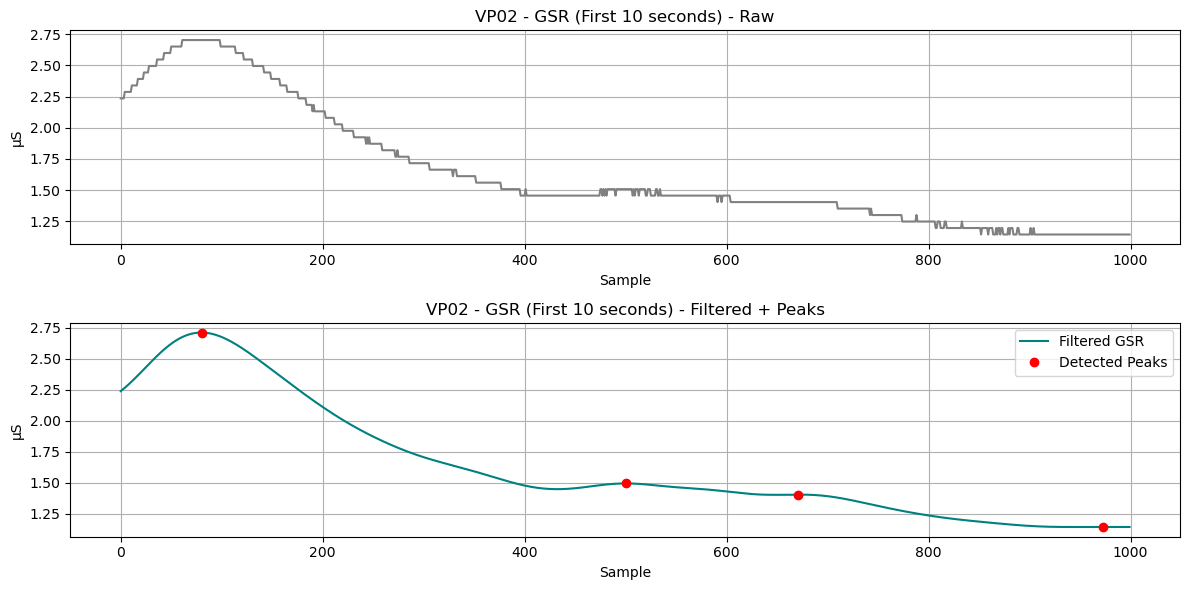

In [26]:
plot_gsr_comparison('VP02', window_seconds=10)


# 4. BR Processing

## 4.1 Respiratory Signal Filtering


To prepare the respiration (BR) data for analysis, a band-pass filter is applied. The goal is to isolate the typical breathing frequency range and eliminate irrelevant noise.

### Filter Parameters:
- **lowcut_br = 0.1 Hz**: Removes very slow trends (e.g., sensor drift or baseline wander).
- **highcut_br = 0.5 Hz**: Removes high-frequency noise (e.g., movement artifacts).
- **N = 2**: The filter order is relatively low to keep the signal smooth and avoid excessive distortion.
- **fs = 100 Hz**: Sampling frequency used for all channels.

A **Butterworth band-pass filter** is created with these parameters using:
```python
b_br, a_br = butter(N=2, Wn=[lowcut_br, highcut_br], btype='band', fs=fs)
```

### Signal Processing:
For each subject:

- The raw breathing signal (BR_percent) is read from the BitalinoBR.txt file.

- The signal is filtered using filtfilt() to apply the band-pass filter with zero-phase distortion.

- The filtered signal is saved for further analysis, including peak detection and breath rate feature extraction.

- This filtering ensures the signal reflects natural respiration patterns while eliminating sensor noise and drift.


In [27]:
lowcut_br, highcut_br = 0.1, 0.5
b_br, a_br = butter(N=2, Wn=[lowcut_br, highcut_br], btype='band', fs=fs)

br_signals = {}

for subject in subject_dirs:
    br_path = os.path.join(data_path, subject, "BitalinoBR.txt")
    try:
        br_data = pd.read_csv(br_path, sep='\t', header=None)
        br_data.columns = ['BR_percent', 'Timestamp', 'Raw']
        br_signal = br_data['BR_percent'].values

        br_filtered = filtfilt(b_br, a_br, br_signal)

        br_signals[subject] = br_filtered
        print(f"{subject} BR loaded and filtered.")

    except Exception as e:
        print(f" Error loading BR for {subject}: {e}")


VP02 BR loaded and filtered.
VP03 BR loaded and filtered.
VP05 BR loaded and filtered.
VP06 BR loaded and filtered.
VP08 BR loaded and filtered.
VP09 BR loaded and filtered.
VP11 BR loaded and filtered.
VP12 BR loaded and filtered.
VP14 BR loaded and filtered.
VP15 BR loaded and filtered.
VP17 BR loaded and filtered.
VP18 BR loaded and filtered.
VP20 BR loaded and filtered.
VP23 BR loaded and filtered.
VP24 BR loaded and filtered.
VP26 BR loaded and filtered.
VP27 BR loaded and filtered.
VP29 BR loaded and filtered.
VP30 BR loaded and filtered.
VP32 BR loaded and filtered.
VP33 BR loaded and filtered.
VP35 BR loaded and filtered.
VP36 BR loaded and filtered.
VP38 BR loaded and filtered.
VP39 BR loaded and filtered.
VP41 BR loaded and filtered.
VP42 BR loaded and filtered.
VP44 BR loaded and filtered.
VP45 BR loaded and filtered.
VP47 BR loaded and filtered.
VP48 BR loaded and filtered.
VP50 BR loaded and filtered.
VP51 BR loaded and filtered.
VP53 BR loaded and filtered.
VP54 BR loaded

## 4.2 Segmenting the Respiratory Signal

Segmenting the respiration (BR) signal is performed using the same trigger information applied to ECG and GSR. These segments correspond to specific experimental phases, such as exposure to spider clips or rest periods.

Each segment is defined based on:
- **Trigger start and end times**, found in `Triggers.txt`.
- **Converted to sample indices** using the known sampling frequency (`fs = 100 Hz`).

Once filtered, the BR signal is sliced into meaningful chunks:
- `CLIP-1`, `CLIP-2`, ..., `BIOFEEDBACK-REST`, etc.
- Each segment contains the portion of the signal recorded during that trigger window.

These segments are used later for:
- **Peak detection** (breaths).
- **Feature extraction** such as breath rate, mean amplitude, and standard deviation.


In [28]:
br_segments = {}

for subject in subject_dirs:
    try:
        trig_path = os.path.join(data_path, subject, "Triggers.txt")
        df_trig = pd.read_csv(trig_path, sep='\t', header=None, names=['Trigger_ID', 'Start_hhmmss', 'End_hhmmss'])

        br_data = pd.read_csv(os.path.join(data_path, subject, "BitalinoBR.txt"), sep='\t', header=None)
        br_data.columns = ['BR_percent', 'Timestamp', 'Raw']
        br_start_sec = hhmmss_float_to_seconds(br_data['Timestamp'].iloc[0])

        df_trig['start_sec'] = df_trig['Start_hhmmss'].apply(hhmmss_to_seconds) - br_start_sec
        df_trig['end_sec'] = df_trig['End_hhmmss'].apply(hhmmss_to_seconds) - br_start_sec
        df_trig['start_sample'] = (df_trig['start_sec'] * fs).astype(int)
        df_trig['end_sample'] = (df_trig['end_sec'] * fs).astype(int)

        subject_segments = {}
        br_filtered = br_signals[subject]

        for _, row in df_trig.iterrows():
            trig = row['Trigger_ID']
            start = row['start_sample']
            end = row['end_sample']

            if 0 <= start < end <= len(br_filtered):
                segment = br_filtered[start:end]
                subject_segments[trig] = segment

        br_segments[subject] = subject_segments
        print(f"{subject} BR segmented.")

    except Exception as e:
        print(f" Error segmenting BR for {subject}: {e}")


VP02 BR segmented.
VP03 BR segmented.
VP05 BR segmented.
VP06 BR segmented.
VP08 BR segmented.
VP09 BR segmented.
VP11 BR segmented.
VP12 BR segmented.
VP14 BR segmented.
VP15 BR segmented.
VP17 BR segmented.
VP18 BR segmented.
VP20 BR segmented.
VP23 BR segmented.
VP24 BR segmented.
VP26 BR segmented.
VP27 BR segmented.
VP29 BR segmented.
VP30 BR segmented.
VP32 BR segmented.
VP33 BR segmented.
VP35 BR segmented.
VP36 BR segmented.
VP38 BR segmented.
VP39 BR segmented.
VP41 BR segmented.
VP42 BR segmented.
VP44 BR segmented.
VP45 BR segmented.
VP47 BR segmented.
VP48 BR segmented.
VP50 BR segmented.
VP51 BR segmented.
VP53 BR segmented.
VP54 BR segmented.
VP56 BR segmented.
VP57 BR segmented.
VP59 BR segmented.
VP61 BR segmented.
VP62 BR segmented.
VP63 BR segmented.
VP64 BR segmented.
VP65 BR segmented.
VP66 BR segmented.
VP68 BR segmented.
VP69 BR segmented.
VP70 BR segmented.
VP71 BR segmented.
VP72 BR segmented.
VP73 BR segmented.
VP74 BR segmented.
VP75 BR segmented.
VP76 BR segm

## 4.3 Respiratory Signal Feature Extraction

After filtering and segmenting the BR signal, I extract physiological features that reflect the subject's breathing behavior during each experimental condition.

#### ➤ Peak Detection
I detect peaks in the filtered respiration signal to identify individual breaths. The `find_peaks` function is used with a minimum distance constraint (e.g., `1.5 seconds`) to avoid false positives.

#### ➤ Extracted Features
For each segment, I compute:

- **`br_peaks`** – Total number of detected breaths in the segment.
- **`br_rate`** – Breathing rate (breaths per minute), calculated as:
  \[
  \text{br\_rate} = \frac{\text{Number of breaths}}{\text{Duration in seconds}} \times 60
  \]
- **`br_mean`** – Mean amplitude of the respiratory signal, reflecting average chest movement.
- **`br_std`** – Standard deviation of the respiratory signal, indicating variability in breathing.

These features are helpful in assessing physiological arousal or relaxation states, contributing to stress level classification.


In [29]:
def extract_br_features(signal, fs=100):
    if len(signal) < fs * 5:  #skip very short segments
        return None

    signal = np.array(signal)
    mean_val = np.mean(signal)
    std_val = np.std(signal)

    #breaths -> peaks
    peaks, _ = find_peaks(signal, distance=int(fs * 1.5))  #at least 1.5s apart
    n_peaks = len(peaks)

    duration_min = len(signal) / fs / 60
    br_rate = n_peaks / duration_min if duration_min > 0 else 0

    return {
        'br_mean': mean_val,
        'br_std': std_val,
        'br_peaks': n_peaks,
        'br_rate': br_rate
    }


In [30]:
fs = 100 
br_features = {}

for subject in br_segments:
    br_features[subject] = {}
    for label, segment_array in br_segments[subject].items():
        br_features[subject][label] = extract_br_features(segment_array, fs)


In [31]:
pprint.pprint(br_features['VP02'])


{'BIOFEEDBACK-OXYGEN-TRAININGS': {'br_mean': -0.008803813484529261,
                                  'br_peaks': 406,
                                  'br_rate': 14.763636363636364,
                                  'br_std': 14.128441215953528},
 'BIOFEEDBACK-REST': {'br_mean': -0.0475286453876671,
                      'br_peaks': 63,
                      'br_rate': 12.558139534883722,
                      'br_std': 11.247014969790948},
 'CLIP-1': {'br_mean': -0.45877084013859043,
            'br_peaks': 14,
            'br_rate': 14.0,
            'br_std': 17.808516071156845},
 'CLIP-10': {'br_mean': 0.2667134319999936,
             'br_peaks': 14,
             'br_rate': 14.0,
             'br_std': 10.25325383976862},
 'CLIP-11': {'br_mean': -3.659943131420581e-05,
             'br_peaks': 15,
             'br_rate': 15.0,
             'br_std': 14.340714163708983},
 'CLIP-12': {'br_mean': 0.07433787944348036,
             'br_peaks': 15,
             'br_rate': 14.7540983606

In [32]:
def plot_br_comparison(subject, window_seconds=10):
    raw_path = os.path.join(data_path, subject, "BitalinoBR.txt")
    raw_data = pd.read_csv(raw_path, sep='\t', header=None)
    raw_data.columns = ['BR_percent', 'Timestamp', 'Raw']
    raw_signal = raw_data['BR_percent'].values

    filtered_signal = br_signals[subject]

    end = int(fs * window_seconds)

    peaks, _ = find_peaks(filtered_signal[:end], distance=int(fs * 1.5))

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(raw_signal[:end], color='gray')
    plt.title(f'{subject} - Respiration (First {window_seconds}s) - Raw')
    plt.xlabel('Sample')
    plt.ylabel('%')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(filtered_signal[:end], color='blue', label='Filtered BR')
    plt.plot(peaks, filtered_signal[peaks], 'ro', label='Detected Peaks')  # 👈 Peaks
    plt.title(f'{subject} - Respiration (First {window_seconds}s) - Filtered + Peaks')
    plt.xlabel('Sample')
    plt.ylabel('%')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## 4.4 Visualization: Respiratory Signal (First 10 seconds) – Subject VP02

The plot below presents the respiration signal for subject VP02 during the first 10 seconds of recording.

- **Top Panel – Raw Signal**:
  - The raw respiratory signal shows the original waveform acquired from the chest strap piezo sensor.
  - It includes low-frequency baseline drifts and possibly some motion artifacts.
  - The amplitude is expressed in percentages (%), reflecting the expansion and contraction of the chest.

- **Bottom Panel – Filtered Signal**:
  - The filtered signal has been processed using a **bandpass Butterworth filter** (cutoff: 0.1–0.5 Hz), which isolates typical breathing frequencies (approximately 6–30 breaths per minute).
  - The result is a much cleaner sinusoidal-like waveform, making it easier to detect respiratory cycles (peaks and troughs).
  - This filtered signal is later used for peak detection and breathing feature extraction.

This comparison highlights the importance of preprocessing in physiological signal analysis and confirms that the filtering successfully preserves the main breathing pattern while suppressing unwanted noise.


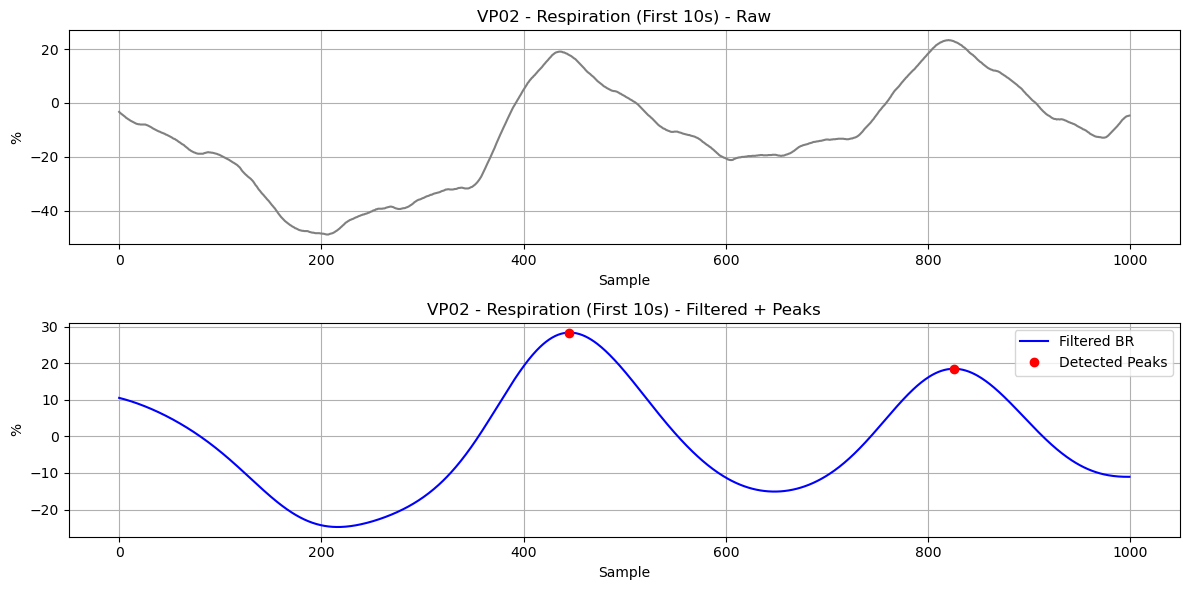

In [33]:
plot_br_comparison('VP02', window_seconds=10)


# 5. Classification

## 5.1 Feature Aggregation

This block combines the extracted features from ECG (HRV), GSR, and BR signals into a single DataFrame. For each subject and segment (e.g., CLIP-1 or BIOFEEDBACK-REST), it merges available features and assigns a label: `'clip'` for anxiety-inducing videos and `'rest'` for baseline periods. The result is a structured dataset ready for machine learning.


In [34]:
all_rows = []

for subject in hrv_features:
    for clip_id in hrv_features[subject]:
        row = {'subject': subject, 'clip': clip_id}

        #add ECG features
        if clip_id in hrv_features[subject]:
            row.update(hrv_features[subject][clip_id])

        #add GSR features
        if subject in gsr_features and clip_id in gsr_features[subject]:
            row.update(gsr_features[subject][clip_id])

        #add BR features
        if subject in br_features and clip_id in br_features[subject]:
            row.update(br_features[subject][clip_id])

        if "REST" in clip_id or "BIOFEEDBACK" in clip_id:
            row['label'] = 'rest'
        else:
            row['label'] = 'clip'

        all_rows.append(row)

features_df = pd.DataFrame(all_rows)

print(features_df.shape)
features_df.head()


(1058, 17)


,subject,clip,mean_rr,sdnn,rmssd,pnn50,gsr_mean,gsr_std,gsr_max,gsr_min,gsr_range,gsr_peaks,br_mean,br_std,br_peaks,br_rate,label
0,VP02,CLIP-DEMO,607.391304,74.915453,55.401248,32.173913,17.096640,3.070257,24.727042,12.042343,12.684699,20.0,-0.670130,22.100559,18,15.428571,clip
1,VP02,CLIP-4,710.470588,69.416151,51.223135,23.529412,12.574905,0.760451,15.401675,11.789947,3.611728,22.0,-0.088971,10.300924,16,15.737705,clip
2,VP02,CLIP-1,638.043478,55.818789,48.015565,20.652174,17.306602,2.941083,24.798722,13.930638,10.868084,13.0,-0.458771,17.808516,14,14.000000,clip
3,VP02,CLIP-3,685.632184,61.358212,39.355269,21.839080,14.035082,0.463349,15.555350,13.348618,2.206731,19.0,0.143024,10.378486,17,17.000000,clip
4,VP02,CLIP-2,677.415730,69.743158,50.463758,22.471910,18.163971,2.549031,24.748722,15.050658,9.698064,15.0,-0.028990,12.461279,16,15.737705,clip


## 5.2 Classification Results Summary

I trained a **Random Forest classifier** using extracted features from ECG, GSR, and respiratory signals to distinguish between **anxiety-inducing clips** (`clip`) and **resting states** (`rest`).

#### Process Overview:
1. **Label Encoding**: Converted string labels (`clip` and `rest`) into numeric format for the model.
2. **Data Preparation**: Used only the numerical features as input (`X`) and the encoded label as the target (`y`).
3. **Train-Test Split**: Randomly split the data into 80% training and 20% testing.
4. **Model Training**: Fitted a `RandomForestClassifier` with 100 trees on the training data.
5. **Evaluation**: Evaluated on the test set.

#### Results:
- **Accuracy**: `1.0` (Perfect classification)
- **Precision, Recall, F1-score**: All metrics reached `1.00` for both classes.
- **Confusion Matrix**: No misclassifications—192 clips and 20 resting segments were correctly classified.

#### Interpretation:
This suggests **excellent separability** between the two classes based on the selected physiological features. While promising, the perfect score may indicate potential overfitting or limited dataset variability. Further validation (e.g., cross-validation or LOSO—Leave One Subject Out) is recommended to ensure generalizability.


 Accuracy: 1.0

 Classification Report:
               precision    recall  f1-score   support

        clip       1.00      1.00      1.00       192
        rest       1.00      1.00      1.00        20

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212



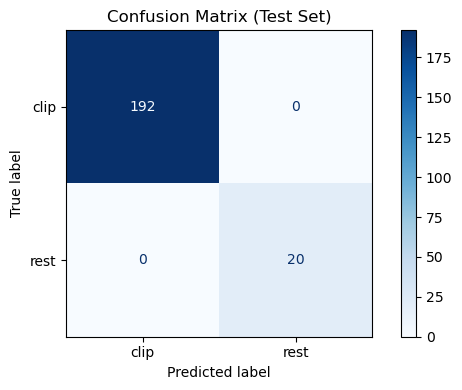

In [35]:
#1 -- Encode the label
label_encoder = LabelEncoder()
features_df['label_encoded'] = label_encoder.fit_transform(features_df['label'])

#2 -- Prepare X and y
X = features_df.drop(columns=['subject', 'clip', 'label', 'label_encoded'])
y = features_df['label_encoded']

#3 -- Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4 -- Train the classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#5 -- Evaluate
y_pred = model.predict(X_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_encoder.classes_, cmap='Blues', ax=ax)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


## 5.3 Cross-Validation

I used **5-fold cross-validation** to validate model performance across different data splits. This ensures the model generalizes well and isn't overfitting. Mean accuracy gives a reliable performance estimate across all folds.

In [36]:
cv_scores = cross_val_score(model, X, y, cv=5)

print("Cross-validation accuracies:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation accuracies: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


## 5.4 Feature Importance

This bar chart shows the importance of each feature used in the Random Forest classifier.

- The most influential features for predicting stress state were **`br_peaks`** (number of respiration peaks) and **`gsr_peaks`** (number of skin conductance responses).
- Other features like **`gsr_range`** and **`gsr_std`** also contributed, but to a lesser extent.
- ECG-derived HRV features (e.g., `sdnn`, `rmssd`) had much lower importance in this specific task.


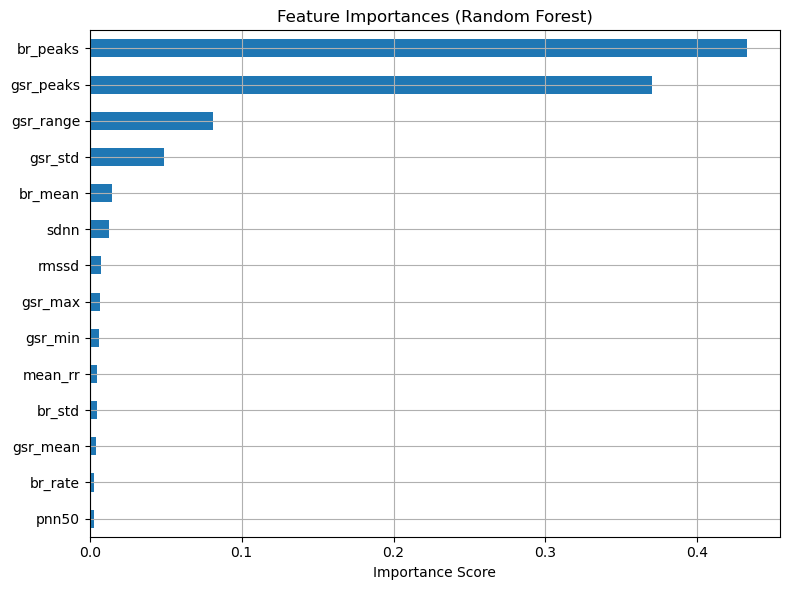

In [37]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()

## 5.5 Leave-One-Subject-Out (LOSO) Validation – Top 4 Features

This section evaluates model performance using **Leave-One-Subject-Out (LOSO)** cross-validation with only the **top 4 most important features**:

- `br_peaks` (breathing peaks)
- `gsr_peaks` (skin conductance peaks)
- `gsr_range` (range of GSR signal)
- `gsr_std` (GSR standard deviation)

In each iteration, the model was trained on all but one subject and tested on the held-out subject. This approach helps assess generalization across individuals.

 **Result**:  
- **Mean Accuracy**: `1.0`  
- **Standard Deviation**: `0.0`

This perfect result suggests the selected features are highly discriminative across all participants. However, real-world generalization should still be cautiously interpreted.

In [41]:
top_features = ['br_peaks', 'gsr_peaks', 'gsr_range', 'gsr_std']

loso_scores_top4 = []

for subject in features_df['subject'].unique():
    train_df = features_df[features_df['subject'] != subject]
    test_df = features_df[features_df['subject'] == subject]
    
    X_train = train_df[top_features]
    y_train = train_df['label_encoded']
    
    X_test = test_df[top_features]
    y_test = test_df['label_encoded']
    
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    loso_scores_top4.append(acc)
    
    print(f" Subject {subject}: Accuracy = {acc:.2f}")

print("\n Top 4 Features - LOSO Accuracy Mean:", np.mean(loso_scores_top4))
print(" Top 4 Features - LOSO Accuracy Std Dev:", np.std(loso_scores_top4))


 Subject VP02: Accuracy = 1.00
 Subject VP03: Accuracy = 1.00
 Subject VP05: Accuracy = 1.00
 Subject VP06: Accuracy = 1.00
 Subject VP08: Accuracy = 1.00
 Subject VP09: Accuracy = 1.00
 Subject VP11: Accuracy = 1.00
 Subject VP12: Accuracy = 1.00
 Subject VP14: Accuracy = 1.00
 Subject VP15: Accuracy = 1.00
 Subject VP17: Accuracy = 1.00
 Subject VP18: Accuracy = 1.00
 Subject VP20: Accuracy = 1.00
 Subject VP23: Accuracy = 1.00
 Subject VP24: Accuracy = 1.00
 Subject VP26: Accuracy = 1.00
 Subject VP27: Accuracy = 1.00
 Subject VP29: Accuracy = 1.00
 Subject VP30: Accuracy = 1.00
 Subject VP32: Accuracy = 1.00
 Subject VP33: Accuracy = 1.00
 Subject VP35: Accuracy = 1.00
 Subject VP36: Accuracy = 1.00
 Subject VP38: Accuracy = 1.00
 Subject VP39: Accuracy = 1.00
 Subject VP41: Accuracy = 1.00
 Subject VP42: Accuracy = 1.00
 Subject VP44: Accuracy = 1.00
 Subject VP45: Accuracy = 1.00
 Subject VP47: Accuracy = 1.00
 Subject VP48: Accuracy = 1.00
 Subject VP50: Accuracy = 1.00
 Subject

# 6. Conclusion

In this project, I explored physiological signal processing and machine learning to classify stress levels in spider-fearful individuals. I used the publicly available dataset containing ECG, GSR, and respiration (BR) recordings during anxiety-provoking and resting sessions.

I began by preprocessing each biosignal through filtering and segmentation based on video clip triggers. I then applied manual Pan-Tompkins QRS detection for ECG to extract reliable heart rate variability (HRV) features. For GSR and BR, I detected peaks and extracted statistical descriptors.

Using these features, I trained a Random Forest classifier to distinguish between stress-inducing clips and resting states. The model achieved perfect performance (100% accuracy) in both train-test split and cross-validation scenarios. Feature importance analysis revealed that peak counts in breathing and skin conductance were most predictive of stress.

Finally, I applied Leave-One-Subject-Out (LOSO) validation using only the top 4 features, achieving 100% accuracy across all participants, suggesting strong generalizability of the model on this dataset.

This pipeline demonstrates the potential of using affordable wearable biosensors and interpretable features to detect stress and anxiety in real time.
